In [20]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_tasks_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names
from samplers import get_data_sampler
from tasks import get_task_sampler
from train import config_load_special
import numpy as np
from utils.manual_solvers import w_sig_NGgenerator, w_sig_NGposterior, w_sig_ridge
import copy



%matplotlib inline
%load_ext autoreload
%autoreload 2

path_dic = {
    "exp_UQ": 
    "exp_L2": 
}

all_experiments = ["exp_UQ", "exp_L2"]

## load everything

model_dic = {}
config_dic = {}
ys_dic = {}
mus_dic = {}
sigs_dic = {}
exempt_dic = {}
predmu_dic = {}
predsigma_dic = {}

bayes_mus_dic = {}
bayes_sigs_dic = {}
ridge_mus_dic = {}
ridge_sigs_dic = {}
OLS_mus_dic = {}
OLS_sigs_dic = {}


for experiment in all_experiments:

    model_path = path_dic[experiment]

    model, _ = get_model_from_run(model_path)

    config = config_load_special(model_path)

    model_dic[experiment] = model

    config_dic[experiment] = config

# generate test data
sample_key = list(config_dic.keys())[0]

n_dims = config_dic[sample_key].model.n_dims
batch_size = 20*config_dic[sample_key].training.batch_size

data_sampler = get_data_sampler(config_dic[sample_key].training.data, n_dims)
xs = data_sampler.sample_xs(b_size=batch_size, n_points=config_dic[sample_key].training.curriculum.points.end)


groups = {
            "original": (20, 20),
            "large_sig": (100, 400),
        }

for experiment in all_experiments:

    for sig_config in list(groups.keys()):


        ## reset w and sigma of task samplers

        mu0 = np.ones(n_dims)

        ## gamma(a, b), mean = a/b, variance = a/b^2
        ## when training, we let a/b=1 and b relatively large

        a0, b0 = groups[sig_config]

        new_ws, new_sigs = w_sig_NGgenerator(a0, b0, mu0, n_dims, batch_size)

        new_exp = experiment + "_" + sig_config

        config_dic[new_exp] = copy.deepcopy(config_dic[experiment])

        config_dic[new_exp].training.task_kwargs["pool_dict"]["w"] = torch.Tensor(np.expand_dims(new_ws, axis=-1))
        config_dic[new_exp].training.task_kwargs["pool_dict"]["sigma"] = torch.Tensor(new_sigs)
        config_dic[new_exp].training.task_kwargs["pool_dict"]["exempt"] = np.zeros(batch_size)

        task_sampler = get_task_sampler(
            config_dic[new_exp].training.task,
            n_dims,
            batch_size,
            **config_dic[new_exp].training.task_kwargs
        )

        task = task_sampler()

        

        mus, ys = task.eval_with_mu(xs)

        ys_dic[new_exp] = ys
        mus_dic[new_exp] = mus


        with torch.no_grad():
            pred = model_dic[experiment](xs, ys)

        if "L2" in new_exp:
            predmu_dic[new_exp] = pred
        else:
            predmu_dic[new_exp] = pred[:, :, 0]

        posterior_mu = np.zeros(predmu_dic[new_exp].shape)
        ridge_mu = np.zeros(predmu_dic[new_exp].shape)

        for selected_index in range(len(predmu_dic[new_exp])):

            # estimated_ws, estimated_sigs = w_sig_NGposterior(xs.numpy()[selected_index], ys.numpy()[selected_index], a0, b0 \
            #                                                 , mu0, MAP_sig=False, bias_adjust=True, pred_Ys= pred[selected_index, :, 0].cpu().numpy())

            estimated_ws, estimated_sigs = w_sig_NGposterior(xs.numpy()[selected_index], ys.numpy()[selected_index], a0, b0 \
                                                            , mu0, MAP_sig=False, bias_adjust=False)


            real_estimated_ws = np.zeros(estimated_ws.shape)
            
            real_estimated_ws[0] = mu0
            # real_estimated_sigs[0] = np.sqrt(b0/(a0-1)* (1+ np.linalg.norm(xs.numpy()[selected_index, 0])**2) + (np.dot(xs.numpy()[selected_index, 0], mu0) - pred[selected_index, 0, 0].cpu().numpy())**2)
            



            # print("adjust_amount: ", np.sqrt(b0/(a0-1)* (1+ np.linalg.norm(xs.numpy()[selected_index, 0])**2) + (np.dot(xs.numpy()[selected_index, 0], mu0) - pred[selected_index, 0, 0].cpu().numpy())**2) \
            #       - np.sqrt(b0/(a0-1)* (1+ np.linalg.norm(xs.numpy()[selected_index, 0])**2)))

            real_estimated_ws[1:] = estimated_ws[:-1]
            
            posterior_mu[selected_index, :] = (np.expand_dims(xs.numpy()[selected_index, :], axis=1) @ np.expand_dims(real_estimated_ws, axis=-1))[:, 0, 0]
            

            ridge_ws, ridge_sigs = w_sig_ridge(xs.numpy()[selected_index], ys.numpy()[selected_index], alpha=0.5)
            
            ridge_mu[selected_index, 1:] = (np.expand_dims(xs.numpy()[selected_index, 1:], axis=1) @ np.expand_dims(ridge_ws[:-1], axis=-1))[:, 0, 0]



        bayes_mus_dic[new_exp] = posterior_mu
        ridge_mus_dic[new_exp] = ridge_mu

# 30min

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


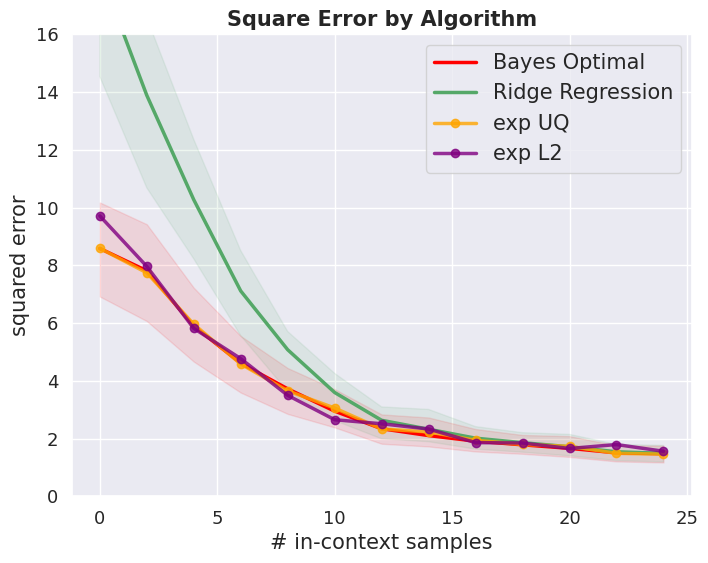

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

def softplus(arr):
    return np.log(1+np.exp(arr))


L2_Bayes = {}
L2_Bayes_fluc = {}
L2_Ridge = {}
L2_Ridge_fluc = {}
L2_model = {}




for sig_config in list(groups.keys()):
    
    sample_experiment = "exp_UQ_" + sig_config

    real_ys = ys_dic[sample_experiment].numpy()
    bayes_mus = bayes_mus_dic[sample_experiment]
    ridge_mus = ridge_mus_dic[sample_experiment]
    
    L2_Bayes[sig_config] = np.square(real_ys - bayes_mus).mean(axis=0)
    L2_Bayes_fluc[sig_config] = np.square(real_ys - bayes_mus).std(axis=0)
    L2_Ridge[sig_config] = np.square(real_ys - ridge_mus).mean(axis=0)
    L2_Ridge_fluc[sig_config] = np.square(real_ys - ridge_mus).std(axis=0)
    

for sig_config in list(groups.keys()):
    for experiment in all_experiments:

        real_ys = ys_dic[experiment + "_" + sig_config].numpy()
        preds = predmu_dic[experiment+ "_" + sig_config].numpy()

        L2_model[experiment+"_"+sig_config] = np.square(real_ys - preds).mean(axis=0)




# Sample data
x_range = 25
x_base = np.arange(0, x_range)
dist_setting = "original"

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(x_base[::2], savgol_filter(L2_Bayes[dist_setting][:x_range], \
                                   window_length=5, polyorder=2)[::2], '-', label='Bayes Optimal', color="red", linewidth=2.5)

ax.fill_between(x_base[::2], L2_Bayes[dist_setting][:x_range][::2] - L2_Bayes_fluc[dist_setting][:x_range][::2]/8, \
                L2_Bayes[dist_setting][:x_range][::2] + L2_Bayes_fluc[dist_setting][:x_range][::2]/8, \
                    color='red', alpha=0.1)


ax.plot(x_base[::2], savgol_filter(L2_Ridge[dist_setting][:x_range], window_length=5, polyorder=2)[::2], \
        '-', label='Ridge Regression', color="g", linewidth=2.5, alpha=1)
ax.fill_between(x_base[::2], L2_Ridge[dist_setting][:x_range][::2] - L2_Ridge_fluc[dist_setting][:x_range][::2]/8, \
                L2_Ridge[dist_setting][:x_range][::2] + L2_Ridge_fluc[dist_setting][:x_range][::2]/8, \
                    color='g', alpha=0.1)

ax.plot(x_base[::2], savgol_filter(L2_model["exp_UQ_"+dist_setting][:x_range], window_length=1, polyorder=0)[::2], \
        'o-', label='exp UQ', color="orange", linewidth=2.5, alpha=0.8)

ax.plot(x_base[::2], savgol_filter(L2_model["exp_L2_"+dist_setting][:x_range], window_length=1, polyorder=0)[::2], \
        'o-', label='exp L2', color="purple", linewidth=2.5, alpha=0.8)


# Labels and title
ax.set_xlabel('# in-context samples', fontsize="15")
ax.set_ylabel('squared error', fontsize="15")
ax.set_ylim(0, 16) 
ax.set_title('Square Error by Algorithm', fontsize="15", fontweight='bold')

ax.xaxis.set_tick_params(labelsize=13)
ax.yaxis.set_tick_params(labelsize=13)

# Grid and legend
ax.grid(True)
ax.legend(fontsize="15")

plt.savefig('figures/exp_LR_L2_compare.eps', format='eps')
plt.savefig('figures/exp_LR_L2_compare.png', format='png')

# Show plot
plt.show()
